In [9]:
import numpy as np
import optuna
import torch
from optuna.integration import PyTorchLightningPruningCallback
from pytorch_lightning.callbacks import EarlyStopping
from sklearn.preprocessing import MaxAbsScaler
import mlflow
from darts.dataprocessing.transformers import Scaler
from darts.datasets import AirPassengersDataset
from darts.metrics import smape
from darts.models import BlockRNNModel
from darts.utils.likelihood_models import GaussianLikelihood
from optuna.integration import MLflowCallback
import pandas as pd
import matplotlib.pyplot as plt
from darts import TimeSeries

In [10]:
VAL_LEN = 36
dataset = pd.read_parquet(r"D:\Git\darts-pipeline\data\dataset\rossmann.parquet")
time_col = "Date"
group_cols = ["Store"]
value_col = ["Sales"]
features = [
    "DayOfWeek",
    "Customers",
    "Open",
    "Promo",
    "SchoolHoliday",
    "month",
    "week",
    "day_of_week",
    "day_of_month",
    "day_of_year",
    "hour",
    "weekend",
    "Sales_lag_1D",
    "Customers_lag_1D",
    "Open_lag_1D",
    "Promo_lag_1D",
    "Sales_lag_2D",
    "Customers_lag_2D",
    "Open_lag_2D",
    "Promo_lag_2D",
    "Sales_lag_3D",
    "Customers_lag_3D",
    "Open_lag_3D",
    "Promo_lag_3D",
    "Sales_lag_4D",
    "Customers_lag_4D",
    "Open_lag_4D",
    "Promo_lag_4D",
    "Sales_lag_5D",
    "Customers_lag_5D",
    "Open_lag_5D",
    "Promo_lag_5D",
    "Sales_lag_6D",
    "Customers_lag_6D",
    "Open_lag_6D",
    "Promo_lag_6D",
    "Sales_lag_7D",
    "Customers_lag_7D",
    "Open_lag_7D",
    "Promo_lag_7D",
    "Sales_lag_8D",
    "Customers_lag_8D",
    "Open_lag_8D",
    "Promo_lag_8D",
    "Sales_lag_9D",
    "Customers_lag_9D",
    "Open_lag_9D",
    "Promo_lag_9D",
    "Sales_lag_10D",
    "Customers_lag_10D",
    "Open_lag_10D",
    "Promo_lag_10D",
    "Sales_lag_11D",
    "Customers_lag_11D",
    "Open_lag_11D",
    "Promo_lag_11D",
    "Sales_lag_12D",
    "Customers_lag_12D",
    "Open_lag_12D",
    "Promo_lag_12D",
    "Sales_lag_13D",
    "Customers_lag_13D",
    "Open_lag_13D",
    "Promo_lag_13D",
    "Sales_lag_14D",
    "Customers_lag_14D",
    "Open_lag_14D",
    "Promo_lag_14D",
    "Sales_lag_15D",
    "Customers_lag_15D",
    "Open_lag_15D",
    "Promo_lag_15D",
    "Sales_lag_16D",
    "Customers_lag_16D",
    "Open_lag_16D",
    "Promo_lag_16D",
    "Sales_lag_17D",
    "Customers_lag_17D",
    "Open_lag_17D",
    "Promo_lag_17D",
    "Sales_lag_18D",
    "Customers_lag_18D",
    "Open_lag_18D",
    "Promo_lag_18D",
    "Sales_lag_19D",
    "Customers_lag_19D",
    "Open_lag_19D",
    "Promo_lag_19D",
    "Sales_window_7D_mean",
    "Customers_window_7D_mean",
    "Open_window_7D_mean",
    "Promo_window_7D_mean",
    "Sales_window_14D_mean",
    "Customers_window_14D_mean",
    "Open_window_14D_mean",
    "Promo_window_14D_mean",
]

In [11]:
def get_ts(df, time_col, group_cols, value_col, covariate_cols, freq="D"):
    y = TimeSeries.from_group_dataframe(
        df, time_col=time_col, group_cols=group_cols, value_cols=value_col, freq=freq
    )

    covariates = TimeSeries.from_group_dataframe(
        df,
        time_col=time_col,
        group_cols=group_cols,
        value_cols=covariate_cols,
        freq=freq,
    )

    return y, covariates


def split_data(df, time_col, group_cols, value_col, covariate_cols, VAL_LEN):
    y, covariates = get_ts(df, time_col, group_cols, value_col, covariate_cols)

    y_train_list = [ts[: -(2 * VAL_LEN)] for ts in y]
    y_test_list = [ts[-VAL_LEN:] for ts in y]
    y_val_list = [ts[-(2 * VAL_LEN) : -VAL_LEN] for ts in y]

    y_scaler = Scaler(scaler=MaxAbsScaler(), global_fit=True)
    covariates_scaler = Scaler(scaler=MaxAbsScaler(), global_fit=True)

    train = y_scaler.fit_transform(y_train_list)
    test = y_scaler.transform(y_test_list)
    val = y_scaler.transform(y_val_list)

    covariates = covariates_scaler.fit_transform(covariates)

    return y, y_scaler, train, test, val, covariates


y, y_scaler, train, test, val, covariates = split_data(
    dataset, time_col, group_cols, value_col, features, VAL_LEN
)

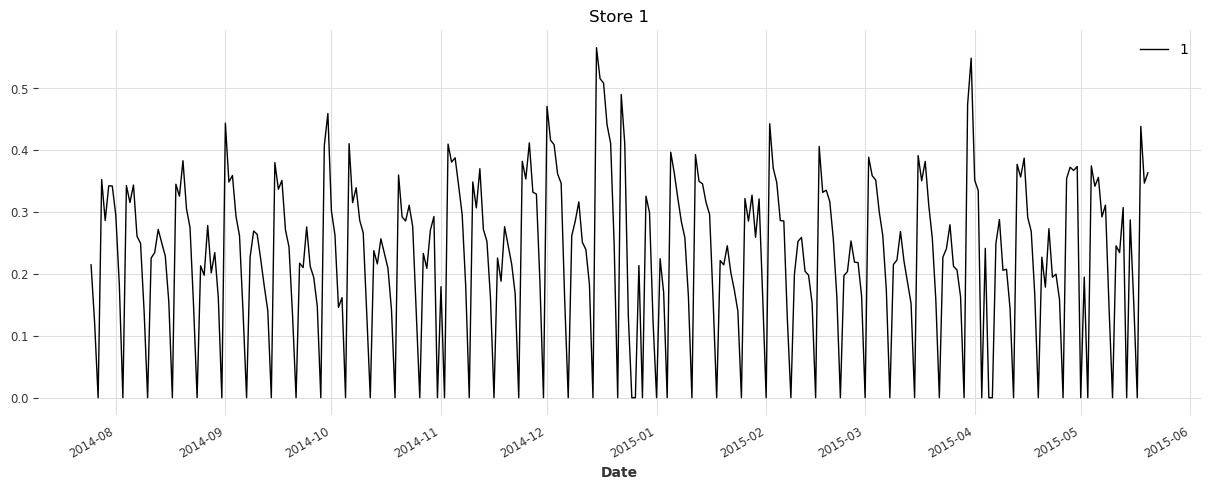

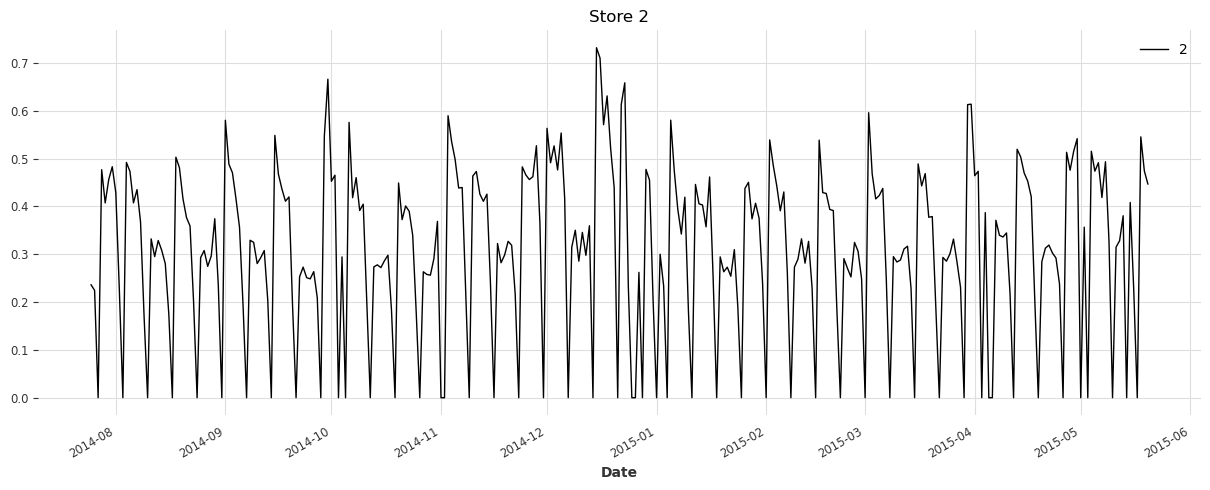

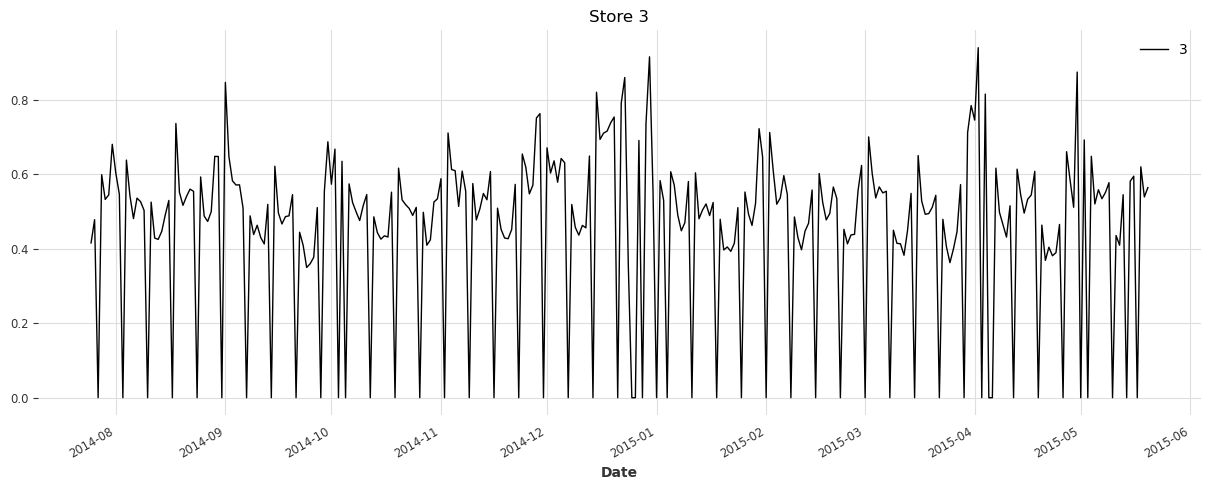

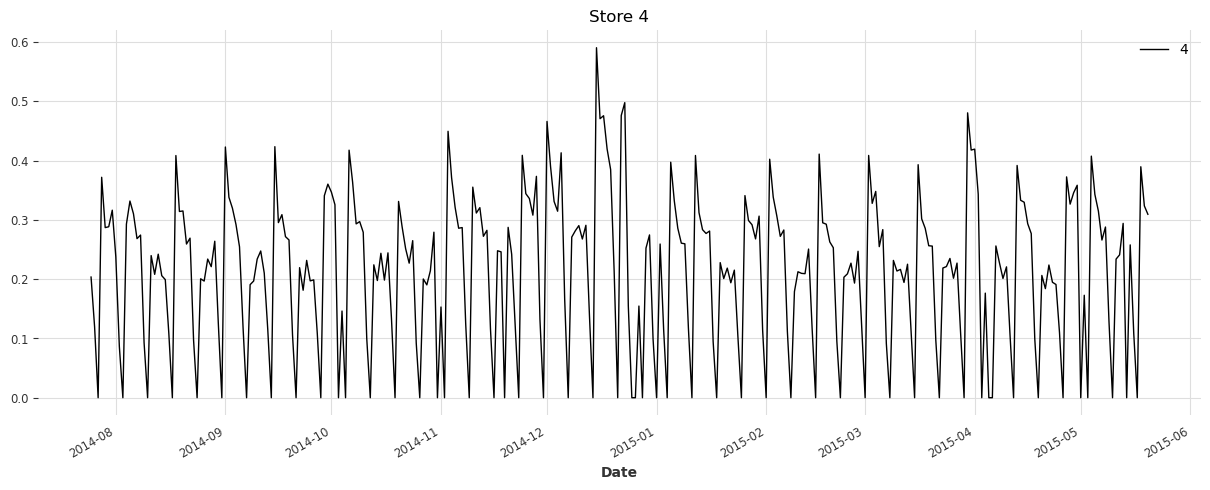

In [20]:
for i in [1, 2, 3, 4]:
    plt.figure(figsize=(15, 5))
    train[i][-300:].plot(label=f"{i}", lw=1)
    plt.title(f"Store {i}")
    plt.legend()
    plt.show()

In [21]:
def eval_model(preds, name, train_set=train, val_set=val):
    smapes = smape(preds, val_set)
    print("{} sMAPE: {:.2f} +- {:.2f}".format(name, np.mean(smapes), np.std(smapes)))

    for i in [1, 2, 3, 4, 5]:
        plt.figure(figsize=(15, 5))
        train_set[i][-100:].plot()
        val_set[i].plot(label="actual")
        preds[i].plot(label="forecast")
        plt.title(f"Store {i}")
        plt.legend()
        plt.show()

In [14]:
in_len = 60
out_len = 14
model = "RNN"
n_rnn_layers = 4
hidden_dim = 47
lr = 0.0007186732721932353
dropout = 0.2999267470430375

In [15]:
pl_trainer_kwargs = {
    "accelerator": "auto",
}

torch.manual_seed(42)

model = BlockRNNModel(
    input_chunk_length=in_len,
    output_chunk_length=out_len,
    model=model,
    n_rnn_layers=n_rnn_layers,
    hidden_dim=hidden_dim,
    batch_size=30,
    n_epochs=50,
    dropout=dropout,
    nr_epochs_val_period=1,
    loss_fn=torch.nn.MSELoss(),
    optimizer_kwargs={"lr": lr},
    likelihood=GaussianLikelihood(),
    pl_trainer_kwargs=pl_trainer_kwargs,
    model_name="BlockRNNModel",
    force_reset=True,
    save_checkpoints=True,
)

model.fit(
    series=train,
    past_covariates=covariates,
    val_past_covariates=covariates,
)

preds = model.predict(
    series=train,
    past_covariates=covariates,
    n=VAL_LEN,
    num_samples=100,
    mc_dropout=True,
)
smapes = smape(test, preds, n_jobs=-1, verbose=True)
smape_val = np.mean(smapes)

print(f"Average model sMAPE is {smape_val}")

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | RNN              | 20.4 K
4 | fc            | Sequential       | 1.3 K 
---------------------------------------------------
21.7 K    Trainable params
0         Non-trainable params
21.7 K    Total params
0.087     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Average model sMAPE is nan


Probabilistic Forecasts sMAPE: 44.68 +- 3.32


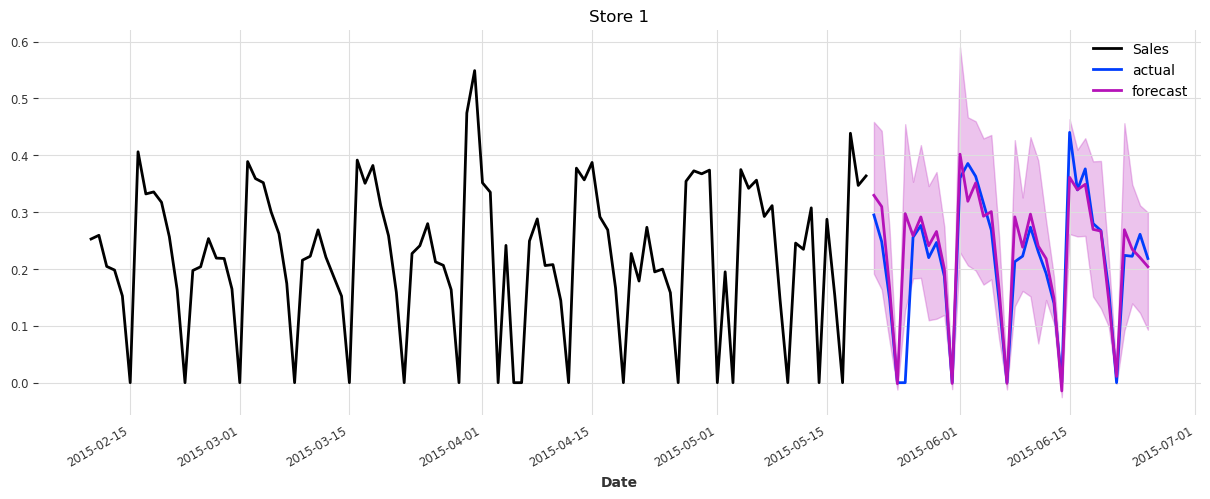

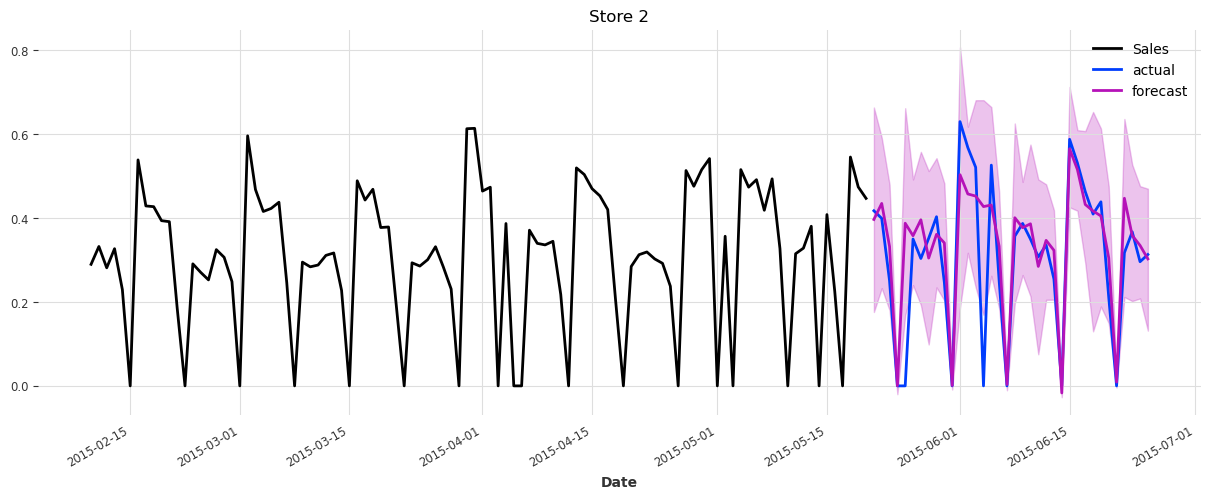

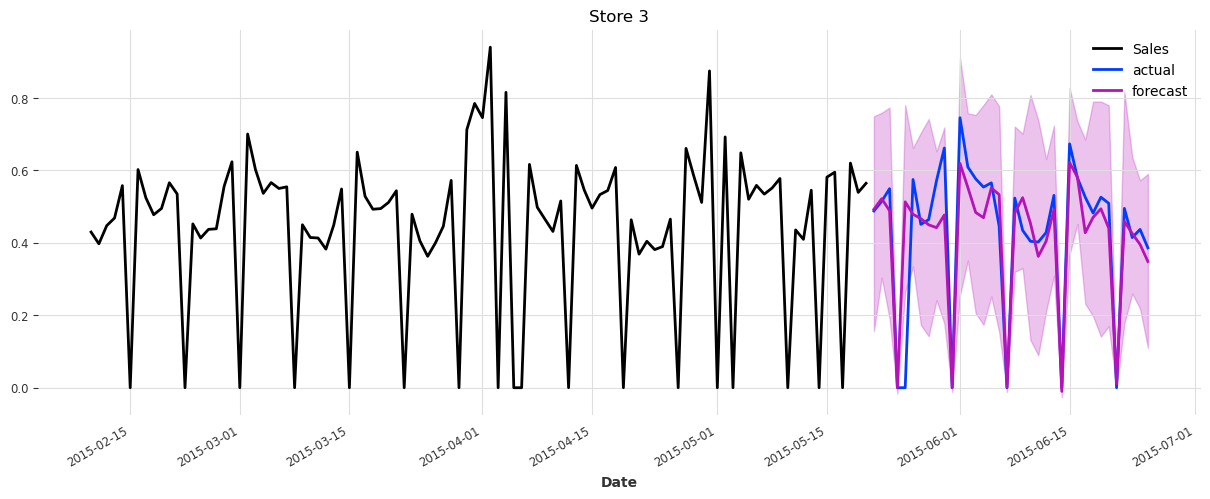

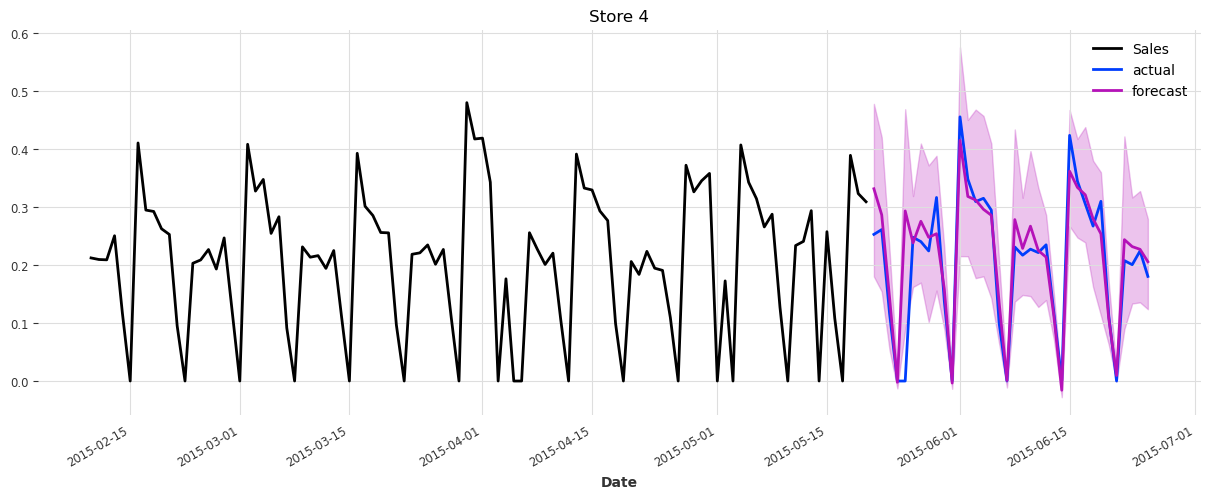

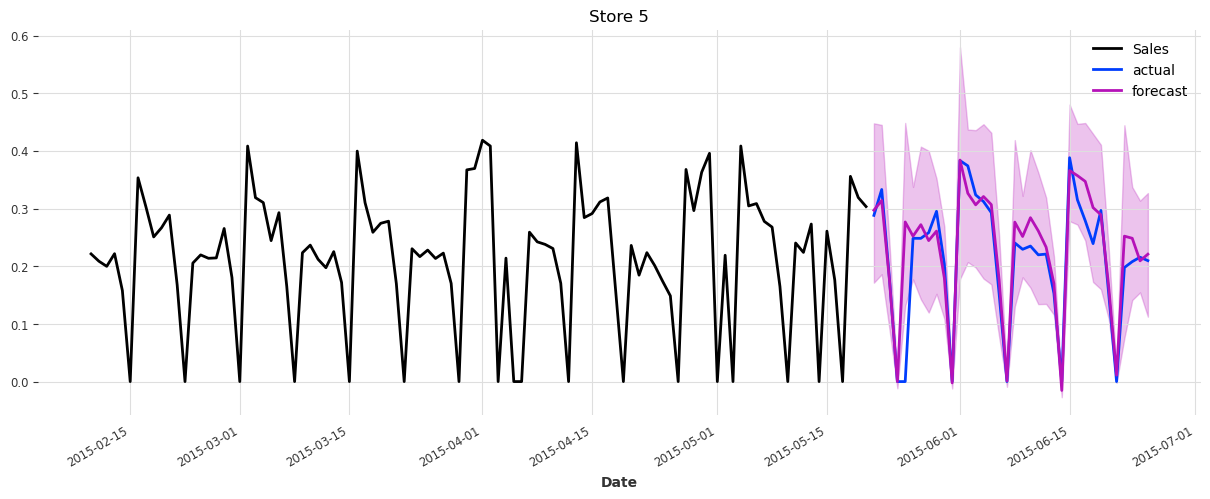

In [22]:
eval_model(preds, "Probabilistic Forecasts")